# **Statistical Information Grid (STING) Algorithm**
STING: A Statistical Information Grid Approach to Spatial Data Mining

Implementation based on the original paper:
"STING: A Statistical Information Grid Approach to Spatial Data Mining"
by Wei Wang, Jiong Yang, and Richard Muntz (1997)

Author: qlbusalim
Date: 2025-01-21
Version: 1.0

Paper Reference:
Wang, W., Yang, J., & Muntz, R. (1997). STING: A statistical information 
grid approach to spatial data mining. In VLDB (Vol. 97, pp. 186-195).

**STING OVERVIEW (from original paper)**

STING divides the spatial area into rectangular cells in a hierarchical manner.
Statistical information of each cell is precomputed and stored. This 
information includes:
- Count: number of points
- Mean: average of attribute values
- Standard Deviation (s): standard deviation of attribute values  
- Min/Max: minimum and maximum values
- Distribution: type of distribution (normal, uniform, etc.)

The spatial area is divided into several levels. Each cell at a high level
is partitioned into a number of smaller cells at the next lower level.

Key Advantages:
1. Query-independent: Grid structure is built once
2. Efficient: Only relevant cells are accessed during query processing
3. Incremental: Easy to update with new data
4. Parallel: Different branches can be processed in parallel

## **Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import math
from typing import List, Dict, Tuple, Optional
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

seed = 2025
np.random.seed(seed)

## **Data Preparation**

In [2]:
# Parameter untuk dataset
n_samples = 5000  # Jumlah data points
n_clusters = 5    # Jumlah cluster spasial
cluster_std = 2.0 # Standar deviasi cluster

# Generate spatial data (Latitude, Longitude) menggunakan make_blobs
X, labels = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters,
    cluster_std=cluster_std,
    center_box=(-50.0, 50.0),  # Range koordinat
    random_state=42
)

# Scale koordinat ke range yang realistis untuk lat/long
# Latitude: -90 to 90, Longitude: -180 to 180
latitude = X[:, 0] * 0.5  # Scale ke range -45 to 45
longitude = X[:, 1] * 1.5  # Scale ke range -75 to 75

# Tambahkan atribut tambahan
# Timestamp (untuk spatio-temporal analysis)
base_date = pd.Timestamp('2024-01-01')
timestamps = [base_date + pd.Timedelta(days=np.random.randint(0, 365)) 
                for _ in range(n_samples)]

# Kategori
categories = np.random.choice(['Type_A', 'Type_B', 'Type_C', 'Type_D'], 
                                size=n_samples)

# Nilai numerik (misalnya magnitude atau intensity)
intensity = np.random.uniform(1.0, 10.0, size=n_samples)

In [3]:
# Buat DataFrame
df = pd.DataFrame({
    'id': range(1, n_samples + 1),
    'latitude': latitude,
    'longitude': longitude,
    'timestamp': timestamps,
    'category': categories,
    'intensity': intensity
})

df.to_csv('Data/sting_synthetic_dataset.csv', index=False)
df.head()

,id,latitude,longitude,timestamp,category,intensity
0,1,-6.335673,70.472573,2024-03-03,Type_A,7.351405
1,2,-3.746062,66.014540,2024-08-10,Type_A,5.508000
2,3,4.477538,32.096310,2024-12-16,Type_A,4.586501
3,4,-18.164851,-53.216543,2024-03-17,Type_A,3.042005
4,5,-16.643046,-53.374676,2024-11-19,Type_B,5.645205


## **EDA**

In [4]:
# Informasi Data
print(f"\n{'='*60}")
print("INFORMASI DATASET UNTUK STING ALGORITHM:")
print(f"{'='*60}")
print(f"Atribut Spasial: latitude, longitude")
print(f"Range Latitude: [{df['latitude'].min():.2f}, {df['latitude'].max():.2f}]")
print(f"Range Longitude: [{df['longitude'].min():.2f}, {df['longitude'].max():.2f}]")
print(f"Jumlah Cluster Spasial: {n_clusters}")
print(f"Total Data Points: {n_samples}")
print(f"Atribut Temporal: timestamp")
print(f"Atribut Kategorikal: category")
print(f"Atribut Numerik: intensity")


INFORMASI DATASET UNTUK STING ALGORITHM:
Atribut Spasial: latitude, longitude
Range Latitude: [-25.32, 14.84]
Range Longitude: [-61.13, 79.17]
Jumlah Cluster Spasial: 5
Total Data Points: 5000
Atribut Temporal: timestamp
Atribut Kategorikal: category
Atribut Numerik: intensity



Visualisasi disimpan sebagai 'sting_dataset_visualization.png'


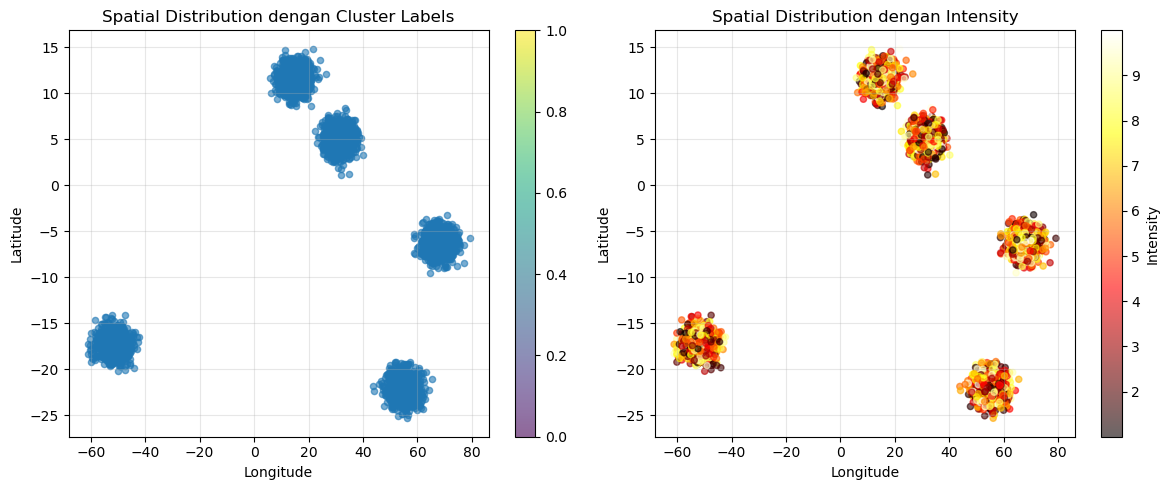

In [5]:
# Visualisasi spatial distribution
plt.figure(figsize=(12, 5))

# Plot 1: Scatter plot dengan cluster labels
plt.subplot(1, 2, 1)
scatter = plt.scatter(df['longitude'], df['latitude'], cmap='viridis', 
                        alpha=0.6, s=20)
plt.colorbar(scatter)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution dengan Cluster Labels')
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot dengan intensity
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['longitude'], df['latitude'], 
                        c=df['intensity'], cmap='hot', 
                        alpha=0.6, s=20)
plt.colorbar(scatter2, label='Intensity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution dengan Intensity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Output/sting_dataset_visualization.png', dpi=300, bbox_inches='tight')
print(f"\nVisualisasi disimpan sebagai 'sting_dataset_visualization.png'")
plt.show()

## **Preprocessing**
### **Cleaning Data**

In [6]:
# Check missing values
print(df.isnull().sum())

# Remove invalid coordinates
df = df[(df['latitude'] >= -90) & (df['latitude'] <= 90)]
df = df[(df['longitude'] >= -180) & (df['longitude'] <= 180)]

# Remove duplicates
df = df.drop_duplicates(subset=['latitude', 'longitude'])

id           0
latitude     0
longitude    0
timestamp    0
category     0
intensity    0
dtype: int64


### **Feature Selection**

In [7]:
# Untuk STING, fitur utama adalah koordinat spasial
X_spatial = df[['latitude', 'longitude']].values

# Fitur tambahan untuk analisis post-clustering
additional_features = ['timestamp', 'category', 'intensity']

## **STING**


### **Config**

In [8]:
grid_levels = 4
min_density_threshold = 0.01  # 1% dari total points

### **HIERARCHICAL CELL STRUCTURE**

In [9]:
class Cell:
    """
    Represents a single cell in the STING hierarchical grid structure.
    
    According to the paper, each cell stores the following statistical parameters:
    - m: count of objects
    - M: mean of attribute values
    - s: standard deviation
    - min: minimum value
    - max: maximum value
    - distribution: type of distribution (normal, uniform, etc.)
    
    Attributes:
        cell_id (tuple): Unique identifier (level, i, j)
        level (int): Hierarchy level of this cell
        bounds (dict): Spatial bounds {min_lat, max_lat, min_lon, max_lon}
        count (int): Number of points in cell (m in paper)
        mean (tuple): Mean coordinates (M in paper)
        std (tuple): Standard deviation (s in paper)
        min_vals (tuple): Minimum values
        max_vals (tuple): Maximum values
        density (float): Points per unit area
        distribution_type (str): Estimated distribution type
        points (list): Indices of points in this cell
        children (list): Child cells at next level
        parent (tuple): Parent cell at previous level
    """
    
    def __init__(self, level: int, i: int, j: int, bounds: Dict[str, float]):
        """
        Initialize a cell in the grid hierarchy.
        
        Args:
            level: Hierarchy level (0 = coarsest, higher = finer)
            i: Row index in grid
            j: Column index in grid
            bounds: Dictionary with min_lat, max_lat, min_lon, max_lon
        """
        self.cell_id = (level, i, j)
        self.level = level
        self.row = i
        self.col = j
        self.bounds = bounds
        
        # Statistical parameters (as defined in STING paper)
        self.count = 0              # m: number of objects
        self.sum_x = 0.0            # For calculating mean
        self.sum_y = 0.0
        self.sum_x2 = 0.0           # For calculating variance/std
        self.sum_y2 = 0.0
        self.mean = (0.0, 0.0)      # M: mean values
        self.std = (0.0, 0.0)       # s: standard deviation
        self.min_vals = (float('inf'), float('inf'))    # min values
        self.max_vals = (float('-inf'), float('-inf'))  # max values
        
        # Additional attributes
        self.density = 0.0
        self.distribution_type = None
        self.points = []            # Store point indices
        self.children = []          # Child cells
        self.parent = None          # Parent cell
        self.is_relevant = False    # For query processing
        
    def add_point(self, point_idx: int, x: float, y: float):
        """
        Add a point to this cell and update statistical parameters.
        
        This implements the statistical computation described in the paper.
        We use incremental formulas to efficiently update statistics.
        
        Args:
            point_idx: Index of the point in original dataset
            x: X coordinate (latitude)
            y: Y coordinate (longitude)
        """
        self.points.append(point_idx)
        self.count += 1
        
        # Update sums for mean calculation
        self.sum_x += x
        self.sum_y += y
        
        # Update sums for variance/std calculation
        self.sum_x2 += x * x
        self.sum_y2 += y * y
        
        # Update min/max
        self.min_vals = (
            min(self.min_vals[0], x),
            min(self.min_vals[1], y)
        )
        self.max_vals = (
            max(self.max_vals[0], x),
            max(self.max_vals[1], y)
        )
    
    def compute_statistics(self):
        """
        Compute final statistics after all points are added.
        
        Implements the statistical formulas from the STING paper:
        - Mean (M) = sum x / m
        - Variance (σ²) = (sum x^2 / m) - M^2
        - Standard Deviation (s) = √(sigma^2)
        - Density = m / area
        """
        if self.count == 0:
            return
        
        # Calculate mean (M in paper)
        self.mean = (
            self.sum_x / self.count,
            self.sum_y / self.count
        )
        
        # Calculate standard deviation (s in paper)
        # Using formula: σ² = E[X²] - (E[X])²
        var_x = (self.sum_x2 / self.count) - (self.mean[0] ** 2)
        var_y = (self.sum_y2 / self.count) - (self.mean[1] ** 2)
        
        # Ensure non-negative (can be slightly negative due to floating point)
        var_x = max(0, var_x)
        var_y = max(0, var_y)
        
        self.std = (math.sqrt(var_x), math.sqrt(var_y))
        
        # Calculate density (points per unit area)
        area = self.get_area()
        if area > 0:
            self.density = self.count / area
        
        # Estimate distribution type
        self.estimate_distribution()
    
    def get_area(self) -> float:
        """Calculate the area of this cell."""
        width = self.bounds['max_lon'] - self.bounds['min_lon']
        height = self.bounds['max_lat'] - self.bounds['min_lat']
        return width * height
    
    def estimate_distribution(self):
        """
        Estimate the distribution type of points in this cell.
        
        The paper mentions that cells can have different distribution types:
        - Normal (Gaussian)
        - Uniform
        - Exponential
        - etc.
        
        This is a simplified implementation using coefficient of variation.
        """
        if self.count < 10:  # Too few points for meaningful test
            self.distribution_type = 'unknown'
            return
        
        # Use coefficient of variation as a simple heuristic
        # CV = σ / μ
        if self.mean[0] != 0 and self.mean[1] != 0:
            cv_x = abs(self.std[0] / self.mean[0])
            cv_y = abs(self.std[1] / self.mean[1])
            
            avg_cv = (cv_x + cv_y) / 2
            
            # Simple classification based on CV
            if avg_cv < 0.3:
                self.distribution_type = 'concentrated'
            elif avg_cv < 0.7:
                self.distribution_type = 'normal'
            else:
                self.distribution_type = 'dispersed'
        else:
            self.distribution_type = 'unknown'
    
    def get_center(self) -> Tuple[float, float]:
        """Get the geometric center of this cell."""
        center_lat = (self.bounds['min_lat'] + self.bounds['max_lat']) / 2
        center_lon = (self.bounds['min_lon'] + self.bounds['max_lon']) / 2
        return (center_lat, center_lon)
    
    def contains_point(self, x: float, y: float) -> bool:
        """Check if a point is within this cell's bounds."""
        return (self.bounds['min_lat'] <= x <= self.bounds['max_lat'] and
                self.bounds['min_lon'] <= y <= self.bounds['max_lon'])
    
    def __repr__(self):
        return (f"Cell(level={self.level}, pos=({self.row},{self.col}), "
                f"count={self.count}, density={self.density:.4f})")

### **HIERARCHICAL GRID STRUCTURE**

In [10]:
class HierarchicalGrid:
    """
    Implements the hierarchical grid structure described in the STING paper.
    
    The spatial area is divided hierarchically into multiple levels, where:
    - Level 0: Coarsest level (fewest cells)
    - Level k: Finest level (most cells)
    
    Each cell at level i is divided into multiple cells at level i+1.
    The paper typically uses a factor of 4 (2x2 subdivision).
    
    Attributes:
        levels (int): Number of hierarchy levels
        root_bounds (dict): Bounds of entire spatial area
        grids (list): List of grids for each level
        cells_per_level (list): Number of cells per dimension at each level
    """
    
    def __init__(self, levels: int = 4, subdivision_factor: int = 2):
        """
        Initialize the hierarchical grid structure.
        
        Args:
            levels: Number of hierarchy levels
            subdivision_factor: How many subdivisions per dimension (typically 2)
        """
        self.levels = levels
        self.subdivision_factor = subdivision_factor
        self.grids = [dict() for _ in range(levels)]  # One dict per level
        self.cells_per_level = []
        self.root_bounds = None
        
    def build(self, X: np.ndarray):
        """
        Build the hierarchical grid structure from data.
        
        This implements Algorithm 1 from the paper (Grid Structure Construction).
        
        Steps:
        1. Determine spatial bounds from data
        2. For each level (coarse to fine):
           a. Calculate number of cells per dimension
           b. Create cells with appropriate bounds
           c. Establish parent-child relationships
        3. Assign data points to finest level cells
        4. Propagate statistics up the hierarchy
        
        Args:
            X: numpy array of shape (n_samples, 2) with [lat, lon]
        """
        print("\n" + "="*70)
        print("BUILDING HIERARCHICAL GRID STRUCTURE")
        print("="*70)
        
        # Step 1: Determine spatial bounds
        min_lat, max_lat = X[:, 0].min(), X[:, 0].max()
        min_lon, max_lon = X[:, 1].min(), X[:, 1].max()
        
        # Add small padding to include boundary points
        padding = 0.001
        self.root_bounds = {
            'min_lat': min_lat - padding,
            'max_lat': max_lat + padding,
            'min_lon': min_lon - padding,
            'max_lon': max_lon + padding
        }
        
        print(f"\nSpatial Bounds:")
        print(f"  Latitude:  [{self.root_bounds['min_lat']:.4f}, "
              f"{self.root_bounds['max_lat']:.4f}]")
        print(f"  Longitude: [{self.root_bounds['min_lon']:.4f}, "
              f"{self.root_bounds['max_lon']:.4f}]")
        
        # Step 2: Create cells for each level
        print(f"\nCreating {self.levels} levels of grid hierarchy...")
        print(f"Subdivision factor: {self.subdivision_factor}")
        
        for level in range(self.levels):
            # Calculate number of cells per dimension
            # Level 0: subdivision_factor cells
            # Level 1: subdivision_factor² cells
            # Level k: subdivision_factor^(k+1) cells
            n_cells = self.subdivision_factor ** (level + 1)
            self.cells_per_level.append(n_cells)
            
            # Calculate cell dimensions
            lat_range = self.root_bounds['max_lat'] - self.root_bounds['min_lat']
            lon_range = self.root_bounds['max_lon'] - self.root_bounds['min_lon']
            
            cell_height = lat_range / n_cells
            cell_width = lon_range / n_cells
            
            # Create cells for this level
            for i in range(n_cells):
                for j in range(n_cells):
                    # Calculate bounds for this cell
                    bounds = {
                        'min_lat': self.root_bounds['min_lat'] + i * cell_height,
                        'max_lat': self.root_bounds['min_lat'] + (i + 1) * cell_height,
                        'min_lon': self.root_bounds['min_lon'] + j * cell_width,
                        'max_lon': self.root_bounds['min_lon'] + (j + 1) * cell_width
                    }
                    
                    # Create cell
                    cell = Cell(level, i, j, bounds)
                    
                    # Establish parent-child relationship
                    if level > 0:
                        parent_i = i // self.subdivision_factor
                        parent_j = j // self.subdivision_factor
                        parent_id = (level - 1, parent_i, parent_j)
                        cell.parent = parent_id
                        
                        if parent_id in self.grids[level - 1]:
                            self.grids[level - 1][parent_id].children.append(cell.cell_id)
                    
                    # Store cell
                    self.grids[level][cell.cell_id] = cell
            
            print(f"  Level {level}: {n_cells}×{n_cells} grid "
                  f"({len(self.grids[level])} cells, "
                  f"cell size: {cell_height:.6f}×{cell_width:.6f})")
        
        # Step 3: Assign points to finest level cells
        print(f"\nAssigning {len(X)} points to finest level (Level {self.levels-1})...")
        finest_level = self.levels - 1
        n_cells = self.cells_per_level[finest_level]
        
        for idx, point in enumerate(X):
            x, y = point[0], point[1]
            
            # Calculate which cell this point belongs to
            i = int((x - self.root_bounds['min_lat']) / cell_height)
            j = int((y - self.root_bounds['min_lon']) / cell_width)
            
            # Handle boundary cases
            i = min(i, n_cells - 1)
            j = min(j, n_cells - 1)
            
            cell_id = (finest_level, i, j)
            
            # Add point to cell
            if cell_id in self.grids[finest_level]:
                self.grids[finest_level][cell_id].add_point(idx, x, y)
        
        # Step 4: Compute statistics for finest level
        print(f"\nComputing statistics for Level {finest_level}...")
        non_empty = 0
        for cell in self.grids[finest_level].values():
            if cell.count > 0:
                cell.compute_statistics()
                non_empty += 1
        
        print(f"  Non-empty cells: {non_empty}/{len(self.grids[finest_level])}")
        
        # Step 5: Propagate statistics up the hierarchy
        print(f"\nPropagating statistics up the hierarchy...")
        self._propagate_statistics_up()
        
        print("\n✓ Grid structure built successfully!")
        self._print_hierarchy_summary()
    
    def _propagate_statistics_up(self):
        """
        Propagate statistical information from fine to coarse levels.
        
        This implements the bottom-up aggregation described in the paper.
        Parent cell statistics are computed from child cell statistics.
        
        Formulas (from paper):
        - m_parent = sum m_children
        - M_parent = (sum m_i * M_i) / m_parent
        - s_parent can be computed from children's statistics
        """
        # Start from second-finest level and go up
        for level in range(self.levels - 2, -1, -1):
            print(f"  Processing Level {level}...")
            
            for cell_id, cell in self.grids[level].items():
                # Aggregate from children
                if not cell.children:
                    continue
                
                total_count = 0
                sum_weighted_x = 0.0
                sum_weighted_y = 0.0
                sum_weighted_x2 = 0.0
                sum_weighted_y2 = 0.0
                global_min_x = float('inf')
                global_min_y = float('inf')
                global_max_x = float('-inf')
                global_max_y = float('-inf')
                
                for child_id in cell.children:
                    child_level = level + 1
                    if child_id in self.grids[child_level]:
                        child = self.grids[child_level][child_id]
                        
                        if child.count > 0:
                            # Aggregate counts
                            total_count += child.count
                            
                            # Weighted means
                            sum_weighted_x += child.count * child.mean[0]
                            sum_weighted_y += child.count * child.mean[1]
                            
                            # For variance computation
                            # E[X²] for parent = weighted avg of E[X²] from children
                            # E[X²] = σ² + μ²
                            child_ex2_x = child.std[0]**2 + child.mean[0]**2
                            child_ex2_y = child.std[1]**2 + child.mean[1]**2
                            sum_weighted_x2 += child.count * child_ex2_x
                            sum_weighted_y2 += child.count * child_ex2_y
                            
                            # Min/Max
                            global_min_x = min(global_min_x, child.min_vals[0])
                            global_min_y = min(global_min_y, child.min_vals[1])
                            global_max_x = max(global_max_x, child.max_vals[0])
                            global_max_y = max(global_max_y, child.max_vals[1])
                
                if total_count > 0:
                    # Set aggregated statistics
                    cell.count = total_count
                    cell.mean = (
                        sum_weighted_x / total_count,
                        sum_weighted_y / total_count
                    )
                    
                    # Compute variance and std
                    ex2_x = sum_weighted_x2 / total_count
                    ex2_y = sum_weighted_y2 / total_count
                    
                    var_x = ex2_x - cell.mean[0]**2
                    var_y = ex2_y - cell.mean[1]**2
                    
                    var_x = max(0, var_x)
                    var_y = max(0, var_y)
                    
                    cell.std = (math.sqrt(var_x), math.sqrt(var_y))
                    
                    cell.min_vals = (global_min_x, global_min_y)
                    cell.max_vals = (global_max_x, global_max_y)
                    
                    # Compute density
                    area = cell.get_area()
                    if area > 0:
                        cell.density = cell.count / area
                    
                    # Estimate distribution
                    cell.estimate_distribution()
    
    def _print_hierarchy_summary(self):
        """Print summary statistics for the hierarchy."""
        print("\n" + "="*70)
        print("HIERARCHY SUMMARY")
        print("="*70)
        
        for level in range(self.levels):
            cells = self.grids[level]
            non_empty = sum(1 for c in cells.values() if c.count > 0)
            
            if non_empty > 0:
                densities = [c.density for c in cells.values() if c.count > 0]
                counts = [c.count for c in cells.values() if c.count > 0]
                
                print(f"\nLevel {level}:")
                print(f"  Grid size: {self.cells_per_level[level]}×{self.cells_per_level[level]}")
                print(f"  Total cells: {len(cells)}")
                print(f"  Non-empty cells: {non_empty} ({non_empty/len(cells)*100:.1f}%)")
                print(f"  Avg points per non-empty cell: {np.mean(counts):.1f}")
                print(f"  Density range: [{min(densities):.6f}, {max(densities):.6f}]")
    
    def get_cell(self, level: int, i: int, j: int) -> Optional[Cell]:
        """Get a specific cell by level and position."""
        cell_id = (level, i, j)
        return self.grids[level].get(cell_id)
    
    def get_cell_by_point(self, x: float, y: float, level: int) -> Optional[Cell]:
        """Find which cell contains a given point at a specific level."""
        n_cells = self.cells_per_level[level]
        
        lat_range = self.root_bounds['max_lat'] - self.root_bounds['min_lat']
        lon_range = self.root_bounds['max_lon'] - self.root_bounds['min_lon']
        
        cell_height = lat_range / n_cells
        cell_width = lon_range / n_cells
        
        i = int((x - self.root_bounds['min_lat']) / cell_height)
        j = int((y - self.root_bounds['min_lon']) / cell_width)
        
        i = min(max(i, 0), n_cells - 1)
        j = min(max(j, 0), n_cells - 1)
        
        return self.get_cell(level, i, j)


### **QUERY PROCESSING (Core of STING)**

In [11]:
class STINGQueryProcessor:
    """
    Implements query processing as described in the STING paper.
    
    The paper describes a top-down query processing approach:
    1. Start at the root (coarsest level)
    2. For each cell, determine if it's relevant to the query
    3. If relevant and not a leaf, examine its children
    4. If relevant and is a leaf, include it in results
    
    This enables efficient spatial queries without examining all cells.
    
    Query Types Supported:
    - Region queries: Find all points in a region
    - Density-based queries: Find high/low density regions
    - Statistical queries: Find regions with specific statistical properties
    """
    
    def __init__(self, grid: HierarchicalGrid):
        """
        Initialize query processor with a hierarchical grid.
        
        Args:
            grid: Built HierarchicalGrid instance
        """
        self.grid = grid
        self.query_result = []
        self.cells_examined = 0
        self.cells_pruned = 0
    
    def density_based_query(self, 
                           min_density_threshold: float,
                           confidence_level: float = 0.95) -> List[Cell]:
        """
        Perform density-based spatial query.
        
        This implements the query processing algorithm from the paper (Algorithm 2).
        
        The algorithm:
        1. Start from root level (Level 0)
        2. For each cell at current level:
           a. Check if cell's density meets threshold
           b. If yes and has children, add children to next level queue
           c. If yes and no children (leaf), add to results
           d. If no, prune this branch
        3. Move to next finer level
        4. Repeat until finest level or no more candidates
        
        Args:
            min_density_threshold: Minimum density threshold (relative to avg density)
            confidence_level: Statistical confidence level (not fully implemented)
            
        Returns:
            List of relevant cells that meet the criteria
        """
        print("\n" + "="*70)
        print("PERFORMING DENSITY-BASED QUERY")
        print("="*70)
        print(f"Parameters:")
        print(f"  Min density threshold: {min_density_threshold}")
        print(f"  Confidence level: {confidence_level}")
        
        # Reset counters
        self.cells_examined = 0
        self.cells_pruned = 0
        relevant_cells = []
        
        # Calculate overall average density for threshold
        finest_level = self.grid.levels - 1
        all_densities = [c.density for c in self.grid.grids[finest_level].values() 
                        if c.count > 0]
        
        if not all_densities:
            print("\n⚠ No data found in grid!")
            return []
        
        avg_density = np.mean(all_densities)
        density_threshold = avg_density * min_density_threshold
        
        print(f"\nDensity Statistics:")
        print(f"  Average density: {avg_density:.6f}")
        print(f"  Calculated threshold: {density_threshold:.6f}")
        print(f"  Min density in data: {min(all_densities):.6f}")
        print(f"  Max density in data: {max(all_densities):.6f}")
        
        # Top-down traversal (Algorithm from paper)
        print(f"\nTop-down hierarchical traversal:")
        
        for level in range(self.grid.levels):
            print(f"\n  Processing Level {level}...")
            level_cells = []
            
            for cell_id, cell in self.grid.grids[level].items():
                self.cells_examined += 1
                
                # Check if cell meets density threshold
                if cell.density >= density_threshold:
                    cell.is_relevant = True
                    level_cells.append(cell)
                    
                    # If this is the finest level, add to results
                    if level == finest_level:
                        relevant_cells.append(cell)
                else:
                    # Prune this branch
                    self.cells_pruned += 1
                    cell.is_relevant = False
            
            print(f"    Relevant cells: {len(level_cells)}")
            print(f"    Pruned cells: {self.cells_pruned}")
            
            # Early termination if no relevant cells
            if not level_cells and level < finest_level:
                print(f"\n  ⚠ No relevant cells at Level {level}, stopping traversal")
                break
        
        print(f"\n" + "="*70)
        print(f"QUERY RESULTS")
        print(f"="*70)
        print(f"  Total cells examined: {self.cells_examined}")
        print(f"  Cells pruned: {self.cells_pruned} "
              f"({self.cells_pruned/self.cells_examined*100:.1f}%)")
        print(f"  Relevant cells found: {len(relevant_cells)}")
        
        total_points = sum(c.count for c in relevant_cells)
        print(f"  Total points in relevant cells: {total_points}")
        
        return relevant_cells
    
    def region_query(self, 
                    min_lat: float, max_lat: float,
                    min_lon: float, max_lon: float) -> List[Cell]:
        """
        Perform region-based spatial query.
        
        Find all cells that intersect with the given rectangular region.
        
        Args:
            min_lat, max_lat: Latitude bounds
            min_lon, max_lon: Longitude bounds
            
        Returns:
            List of cells intersecting the region
        """
        print("\n" + "="*70)
        print("PERFORMING REGION QUERY")
        print("="*70)
        print(f"Query Region:")
        print(f"  Latitude: [{min_lat:.4f}, {max_lat:.4f}]")
        print(f"  Longitude: [{min_lon:.4f}, {max_lon:.4f}]")
        
        relevant_cells = []
        
        # Check intersection at finest level
        finest_level = self.grid.levels - 1
        for cell in self.grid.grids[finest_level].values():
            # Check if cell intersects with query region
            if (cell.bounds['min_lat'] <= max_lat and 
                cell.bounds['max_lat'] >= min_lat and
                cell.bounds['min_lon'] <= max_lon and
                cell.bounds['max_lon'] >= min_lon):
                
                if cell.count > 0:
                    relevant_cells.append(cell)
        
        total_points = sum(c.count for c in relevant_cells)
        print(f"\nResults:")
        print(f"  Cells found: {len(relevant_cells)}")
        print(f"  Total points: {total_points}")
        
        return relevant_cells


### **CLUSTERING USING STING**

In [12]:
class STINGClustering:
    """
    Complete STING clustering algorithm.
    
    This class combines:
    1. Hierarchical grid construction
    2. Query processing for finding high-density regions
    3. Clustering of adjacent high-density cells
    
    The clustering approach:
    1. Build hierarchical grid structure
    2. Find high-density cells using density query
    3. Group adjacent high-density cells into clusters
    4. Assign points to clusters
    
    This follows the general approach described in the STING paper.
    """
    
    def __init__(self,
                 grid_levels: int = 4,
                 min_density_threshold: float = 0.01,
                 subdivision_factor: int = 2):
        """
        Initialize STING clustering.
        
        Args:
            grid_levels: Number of hierarchy levels (typically 3-5)
            min_density_threshold: Threshold for high-density cells (0.0-1.0)
            subdivision_factor: Subdivision per dimension (typically 2)
        """
        self.grid_levels = grid_levels
        self.min_density_threshold = min_density_threshold
        self.subdivision_factor = subdivision_factor
        
        self.grid = None
        self.query_processor = None
        self.labels_ = None
        self.clusters = []
        self.n_clusters_ = 0
        self.n_noise_ = 0
        
    def fit(self, X: np.ndarray):
        """
        Fit STING clustering to data.
        
        Complete workflow:
        1. Build hierarchical grid structure
        2. Query for high-density cells
        3. Cluster adjacent high-density cells
        4. Assign cluster labels to points
        
        Args:
            X: numpy array of shape (n_samples, 2) with [lat, lon]
            
        Returns:
            self
        """
        print("\n" + "="*70)
        print("STING CLUSTERING ALGORITHM")
        print("="*70)
        print(f"Wei Wang, Jiong Yang, Richard Muntz (1997)")
        print(f"\nDataset: {len(X)} points")
        print(f"Parameters:")
        print(f"  Grid levels: {self.grid_levels}")
        print(f"  Min density threshold: {self.min_density_threshold}")
        print(f"  Subdivision factor: {self.subdivision_factor}")
        
        # Step 1: Build hierarchical grid
        self.grid = HierarchicalGrid(
            levels=self.grid_levels,
            subdivision_factor=self.subdivision_factor
        )
        self.grid.build(X)
        
        # Step 2: Query for high-density cells
        self.query_processor = STINGQueryProcessor(self.grid)
        high_density_cells = self.query_processor.density_based_query(
            min_density_threshold=self.min_density_threshold
        )
        
        # Step 3: Cluster adjacent high-density cells
        print("\n" + "="*70)
        print("CLUSTERING HIGH-DENSITY CELLS")
        print("="*70)
        self._cluster_cells(high_density_cells)
        
        # Step 4: Assign labels to all points
        self.labels_ = self._assign_labels(X)
        
        # Summary
        self.n_clusters_ = len(self.clusters)
        self.n_noise_ = np.sum(self.labels_ == -1)
        
        print("\n" + "="*70)
        print("CLUSTERING COMPLETE")
        print("="*70)
        print(f"  Clusters found: {self.n_clusters_}")
        print(f"  Noise points: {self.n_noise_} ({self.n_noise_/len(X)*100:.2f}%)")
        
        return self
    
    def _cluster_cells(self, cells: List[Cell]):
        """
        Group adjacent high-density cells into clusters.
        
        Uses a flood-fill approach:
        1. Start with an unvisited cell
        2. Add it to current cluster
        3. Find all adjacent cells and add them
        4. Repeat until no more adjacent cells
        5. Start new cluster with next unvisited cell
        
        Args:
            cells: List of high-density cells to cluster
        """
        if not cells:
            print("  No high-density cells to cluster")
            return
        
        print(f"\n  Input: {len(cells)} high-density cells")
        print(f"  Using 8-connectivity for adjacency")
        
        # Build a dictionary for fast lookup
        cell_dict = {c.cell_id: c for c in cells}
        visited = set()
        cluster_id = 0
        
        for cell in cells:
            if cell.cell_id in visited:
                continue
            
            # Start new cluster
            cluster_cells = self._expand_cluster(cell, cell_dict, visited)
            
            cluster_size = sum(c.count for c in cluster_cells)
            
            self.clusters.append({
                'id': cluster_id,
                'cells': cluster_cells,
                'size': cluster_size
            })
            
            print(f"  Cluster {cluster_id}: {len(cluster_cells)} cells, "
                  f"{cluster_size} points")
            
            cluster_id += 1
        
        print(f"\n  Total clusters formed: {cluster_id}")
    
    def _expand_cluster(self, 
                       start_cell: Cell, 
                       cell_dict: Dict, 
                       visited: set) -> List[Cell]:
        """
        Expand cluster using flood-fill on adjacent cells.
        
        Args:
            start_cell: Starting cell for expansion
            cell_dict: Dictionary of all high-density cells
            visited: Set of already visited cells
            
        Returns:
            List of cells in this cluster
        """
        cluster_cells = []
        stack = [start_cell]
        
        while stack:
            cell = stack.pop()
            
            if cell.cell_id in visited:
                continue
            
            visited.add(cell.cell_id)
            cluster_cells.append(cell)
            
            # Check 8 adjacent cells
            level, i, j = cell.cell_id
            
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    
                    neighbor_id = (level, i + di, j + dj)
                    
                    if (neighbor_id in cell_dict and 
                        neighbor_id not in visited):
                        stack.append(cell_dict[neighbor_id])
        
        return cluster_cells
    
    def _assign_labels(self, X: np.ndarray) -> np.ndarray:
        """
        Assign cluster labels to all data points.
        
        Args:
            X: Original data array
            
        Returns:
            Array of cluster labels (-1 for noise)
        """
        print("\n  Assigning labels to all points...")
        
        labels = np.full(len(X), -1, dtype=int)
        
        # Create mapping from cell to cluster
        cell_to_cluster = {}
        for cluster in self.clusters:
            for cell in cluster['cells']:
                cell_to_cluster[cell.cell_id] = cluster['id']
        
        # Assign labels based on cell membership
        finest_level = self.grid.levels - 1
        for cell_id, cell in self.grid.grids[finest_level].items():
            if cell_id in cell_to_cluster:
                cluster_id = cell_to_cluster[cell_id]
                for point_idx in cell.points:
                    labels[point_idx] = cluster_id
        
        return labels
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for data.
        
        Args:
            X: Data array
            
        Returns:
            Cluster labels
        """
        return self.labels_
    
    def get_cluster_info(self) -> pd.DataFrame:
        """
        Get detailed information about each cluster.
        
        Returns:
            DataFrame with cluster statistics
        """
        cluster_info = []
        
        for cluster in self.clusters:
            # Calculate cluster bounds and centroid
            all_points_lat = []
            all_points_lon = []
            
            for cell in cluster['cells']:
                all_points_lat.extend([cell.mean[0]] * cell.count)
                all_points_lon.extend([cell.mean[1]] * cell.count)
            
            info = {
                'cluster_id': cluster['id'],
                'n_cells': len(cluster['cells']),
                'n_points': cluster['size'],
                'centroid_lat': np.mean(all_points_lat),
                'centroid_lon': np.mean(all_points_lon),
                'min_lat': min(c.bounds['min_lat'] for c in cluster['cells']),
                'max_lat': max(c.bounds['max_lat'] for c in cluster['cells']),
                'min_lon': min(c.bounds['min_lon'] for c in cluster['cells']),
                'max_lon': max(c.bounds['max_lon'] for c in cluster['cells']),
                'avg_density': np.mean([c.density for c in cluster['cells']])
            }
            
            cluster_info.append(info)
        
        return pd.DataFrame(cluster_info)

### **VISUALIZATION UTILITIES**

In [13]:
class STINGVisualizer:
    """
    Visualization utilities for STING clustering results.
    
    Provides various plots to understand:
    - Cluster distribution
    - Grid structure
    - Hierarchy levels
    - Density patterns
    """
    
    @staticmethod
    def plot_clusters(X: np.ndarray, 
                     labels: np.ndarray,
                     title: str = "STING Clustering Results"):
        """Plot clustering results."""
        plt.figure(figsize=(10, 8))
        
        # Plot points colored by cluster
        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        
        for label, color in zip(unique_labels, colors):
            if label == -1:
                # Noise points in black
                mask = labels == label
                plt.scatter(X[mask, 1], X[mask, 0], 
                          c='black', marker='x', s=20, 
                          alpha=0.3, label='Noise')
            else:
                mask = labels == label
                plt.scatter(X[mask, 1], X[mask, 0],
                          c=[color], s=30, alpha=0.6,
                          edgecolors='black', linewidth=0.5,
                          label=f'Cluster {label}')
        
        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
    
    @staticmethod
    def plot_grid_structure(grid: HierarchicalGrid,
                           X: np.ndarray,
                           labels: np.ndarray,
                           level: int = None):
        """Plot grid structure with data points."""
        if level is None:
            level = grid.levels - 1
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot points
        scatter = ax.scatter(X[:, 1], X[:, 0],
                           c=labels, cmap='tab10',
                           s=20, alpha=0.5,
                           edgecolors='black', linewidth=0.3)
        
        # Draw grid lines
        n_cells = grid.cells_per_level[level]
        
        lat_range = grid.root_bounds['max_lat'] - grid.root_bounds['min_lat']
        lon_range = grid.root_bounds['max_lon'] - grid.root_bounds['min_lon']
        
        cell_height = lat_range / n_cells
        cell_width = lon_range / n_cells
        
        for i in range(n_cells + 1):
            lat_line = grid.root_bounds['min_lat'] + i * cell_height
            lon_line = grid.root_bounds['min_lon'] + i * cell_width
            ax.axhline(y=lat_line, color='red', linestyle='-', 
                      alpha=0.4, linewidth=0.8)
            ax.axvline(x=lon_line, color='red', linestyle='-', 
                      alpha=0.4, linewidth=0.8)
        
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title(f'STING Grid Structure - Level {level} ({n_cells}×{n_cells})',
                    fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Cluster ID')
        plt.tight_layout()
    
    @staticmethod
    def plot_hierarchy(grid: HierarchicalGrid, X: np.ndarray, labels: np.ndarray):
        """Plot all hierarchy levels."""
        n_levels = grid.levels
        fig, axes = plt.subplots(1, n_levels, figsize=(5*n_levels, 5))
        
        if n_levels == 1:
            axes = [axes]
        
        for level in range(n_levels):
            ax = axes[level]
            
            # Plot points
            ax.scatter(X[:, 1], X[:, 0],
                      c=labels, cmap='tab10',
                      s=10, alpha=0.4)
            
            # Draw grid
            n_cells = grid.cells_per_level[level]
            
            lat_range = grid.root_bounds['max_lat'] - grid.root_bounds['min_lat']
            lon_range = grid.root_bounds['max_lon'] - grid.root_bounds['min_lon']
            
            cell_height = lat_range / n_cells
            cell_width = lon_range / n_cells
            
            for i in range(n_cells + 1):
                lat_line = grid.root_bounds['min_lat'] + i * cell_height
                lon_line = grid.root_bounds['min_lon'] + i * cell_width
                ax.axhline(y=lat_line, color='red', linestyle='-', 
                          alpha=0.5, linewidth=1)
                ax.axvline(x=lon_line, color='red', linestyle='-', 
                          alpha=0.5, linewidth=1)
            
            ax.set_title(f'Level {level}\n{n_cells}×{n_cells}',
                        fontweight='bold')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.grid(True, alpha=0.2)
        
        plt.suptitle('STING Hierarchical Grid Structure',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
    
    @staticmethod
    def plot_density_heatmap(grid: HierarchicalGrid, level: int = None):
        """Plot density heatmap for a specific level."""
        if level is None:
            level = grid.levels - 1
        
        n_cells = grid.cells_per_level[level]
        density_grid = np.zeros((n_cells, n_cells))
        
        for cell in grid.grids[level].values():
            if cell.count > 0:
                density_grid[cell.row, cell.col] = cell.density
        
        plt.figure(figsize=(10, 8))
        plt.imshow(density_grid, cmap='YlOrRd', origin='lower',
                  interpolation='nearest')
        plt.colorbar(label='Density')
        plt.title(f'Density Heatmap - Level {level}',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.tight_layout()



### **USAGE AND DEMO**


APPLYING STING CLUSTERING

STING CLUSTERING ALGORITHM
Wei Wang, Jiong Yang, Richard Muntz (1997)

Dataset: 5000 points
Parameters:
  Grid levels: 4
  Min density threshold: 0.01
  Subdivision factor: 2

BUILDING HIERARCHICAL GRID STRUCTURE

Spatial Bounds:
  Latitude:  [-25.3178, 14.8438]
  Longitude: [-61.1319, 79.1663]

Creating 4 levels of grid hierarchy...
Subdivision factor: 2
  Level 0: 2×2 grid (4 cells, cell size: 20.080813×70.149137)
  Level 1: 4×4 grid (16 cells, cell size: 10.040406×35.074568)
  Level 2: 8×8 grid (64 cells, cell size: 5.020203×17.537284)
  Level 3: 16×16 grid (256 cells, cell size: 2.510102×8.768642)

Assigning 5000 points to finest level (Level 3)...

Computing statistics for Level 3...
  Non-empty cells: 43/256

Propagating statistics up the hierarchy...
  Processing Level 2...
  Processing Level 1...
  Processing Level 0...

✓ Grid structure built successfully!

HIERARCHY SUMMARY

Level 0:
  Grid size: 2×2
  Total cells: 4
  Non-empty cells: 4 (100.0%)
 

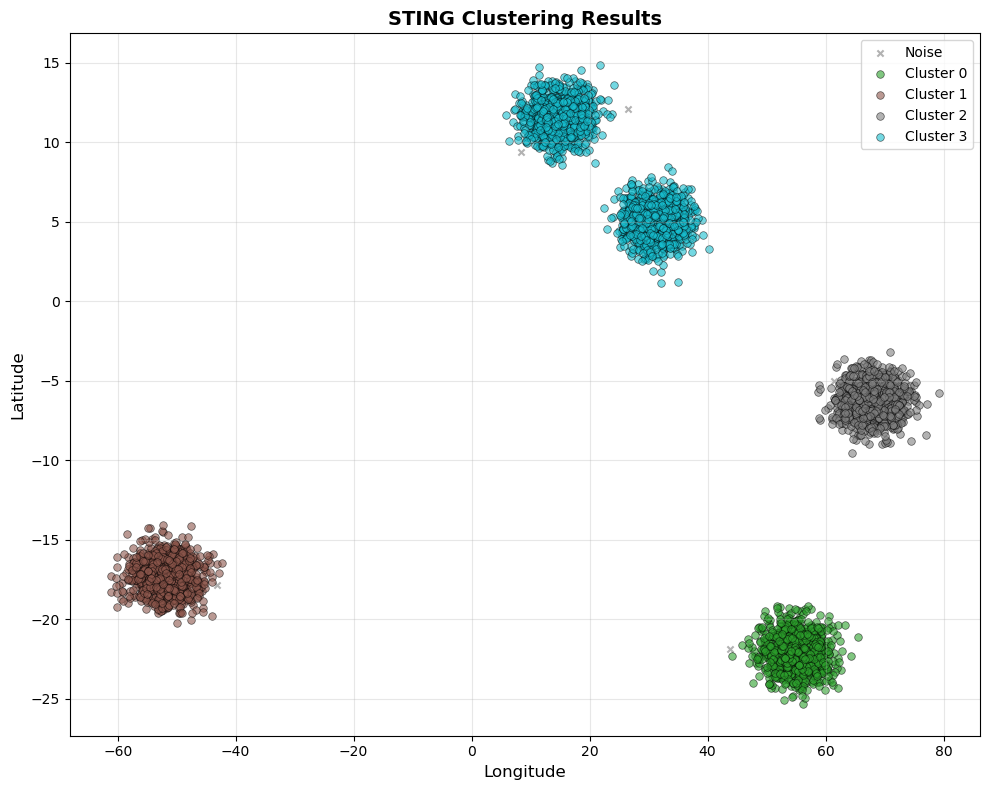

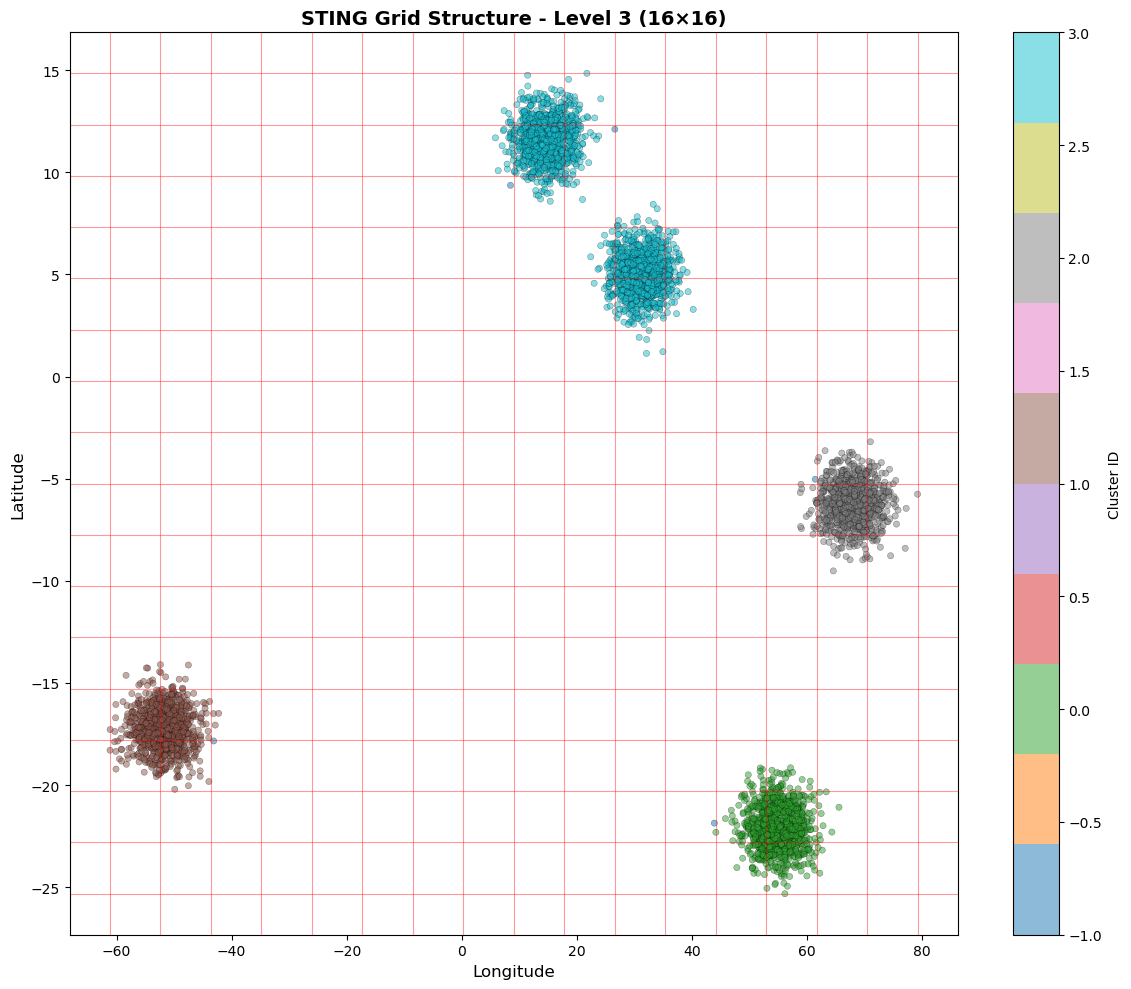

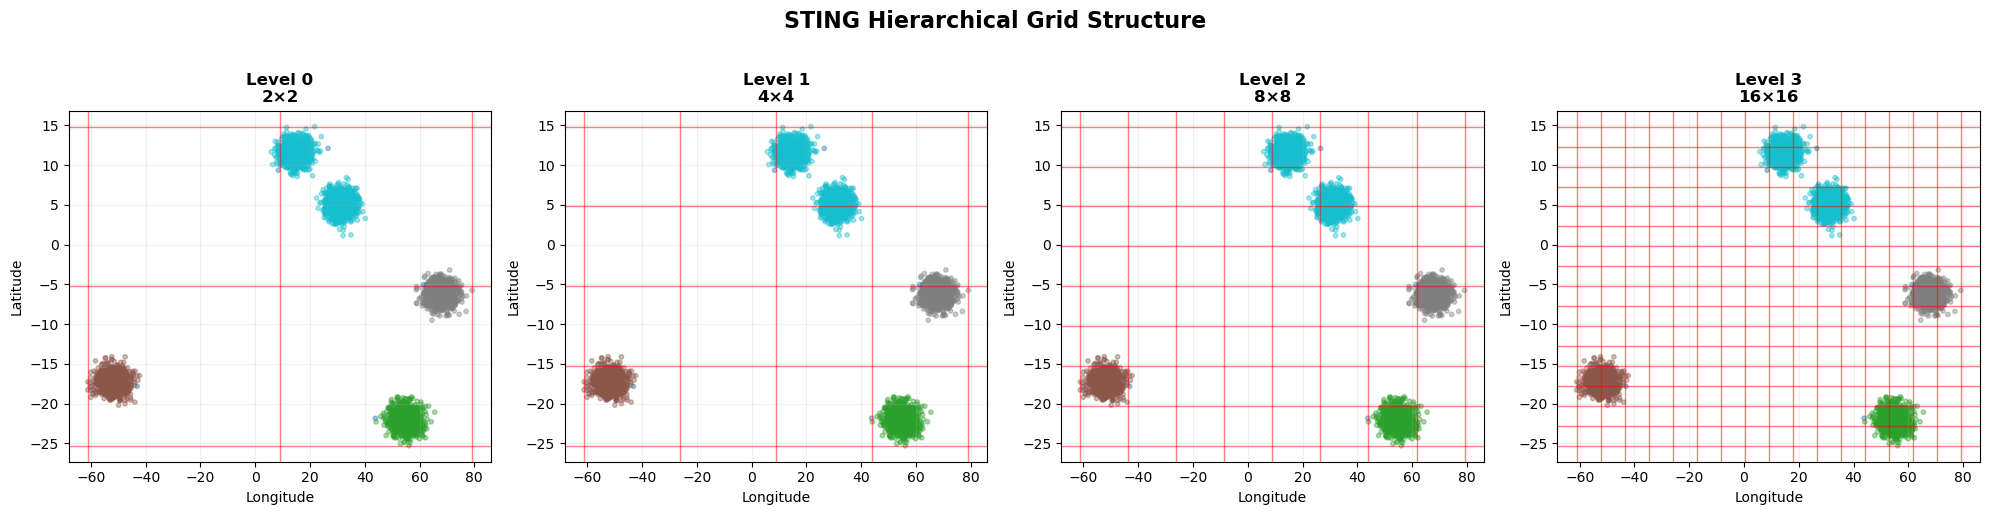

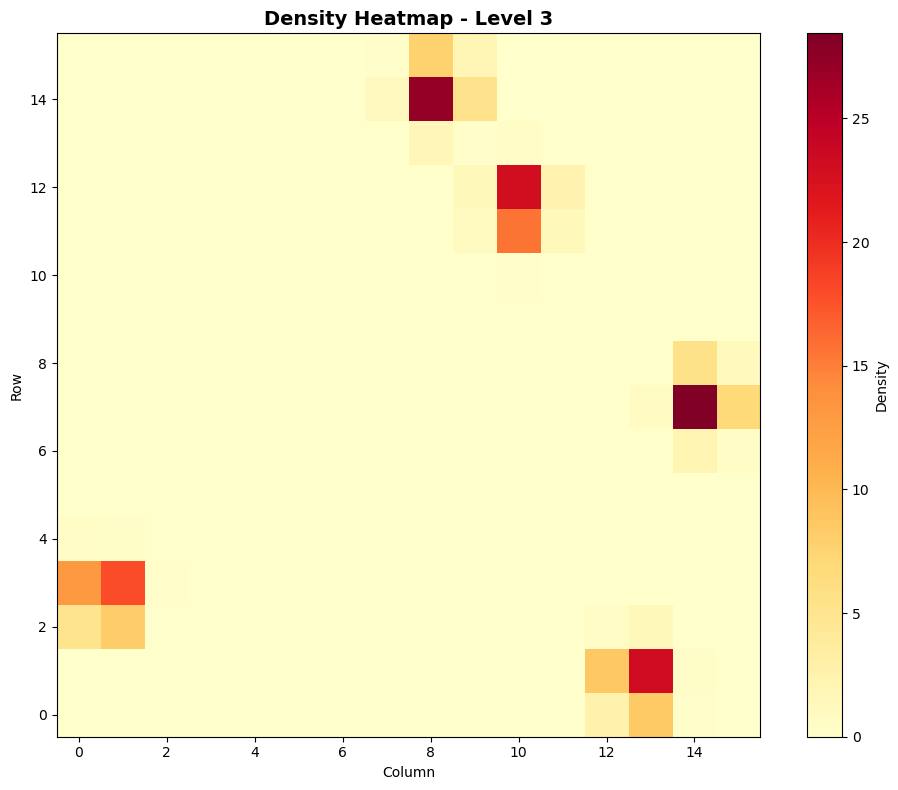


STING ALGORITHM COMPLETED SUCCESSFULLY

Generated Files:
  1. sting_results.csv - Dataset with cluster labels
  2. cluster_info.csv - Detailed cluster information
  3. sting_clusters.png - Clustering results visualization
  4. sting_grid_structure.png - Grid structure visualization
  5. sting_hierarchy.png - Hierarchical levels visualization
  6. sting_density_heatmap.png - Density distribution



In [14]:
def main():
    """
    Demonstration of STING algorithm with synthetic data.
    
    This example shows the complete workflow:
    1. Apply STING clustering
    2. Visualize results
    3. Analyze clusters
    """
    
    # Apply STING Clustering
    print("\n" + "="*70)
    print("APPLYING STING CLUSTERING")
    print("="*70)
    
    # Initialize STING
    sting = STINGClustering(
        grid_levels=4,
        min_density_threshold=0.01,
        subdivision_factor=2
    )
    
    # Fit to data
    sting.fit(X_spatial)
    
    # Get labels
    labels = sting.predict(X_spatial)
    
    # Add to dataframe
    df['sting_cluster'] = labels
    df.to_csv('Output/sting_results.csv', index=False)
    print(f"\n Results saved to 'sting_results.csv'")
    
    # Analyze Results
    print("\n" + "="*70)
    print("ANALYZING CLUSTERING RESULTS")
    print("="*70)
    
    # Get cluster info
    cluster_info = sting.get_cluster_info()
    print("\nCluster Information:")
    print(cluster_info.to_string(index=False))
    
    # Save cluster info
    cluster_info.to_csv('Output/cluster_info.csv', index=False)
    print(f"\nCluster info saved to 'cluster_info.csv'")
    
    # Evaluation metrics
    
    valid_mask = labels >= 0
    if np.sum(valid_mask) > 0 and len(np.unique(labels[valid_mask])) > 1:
        X_valid = X_spatial[valid_mask]
        labels_valid = labels[valid_mask]
        
        silhouette = silhouette_score(X_valid, labels_valid)
        davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
        calinski = calinski_harabasz_score(X_valid, labels_valid)
        
        print("\n" + "="*70)
        print("EVALUATION METRICS")
        print("="*70)
        print(f"Silhouette Score: {silhouette:.4f} (range: -1 to 1, higher better)")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (lower better)")
        print(f"Calinski-Harabasz Score: {calinski:.2f} (higher better)")
    
    # STEP 4: Visualize Results
    print("\n" + "="*70)
    print("STEP 4: CREATING VISUALIZATIONS")
    print("="*70)
    
    visualizer = STINGVisualizer()
    
    # Plot 1: Clustering results
    visualizer.plot_clusters(X_spatial, labels, "STING Clustering Results")
    plt.savefig('Output/sting_clusters.png', dpi=300, bbox_inches='tight')
    print("\nSaved: sting_clusters.png")
    
    # Plot 2: Grid structure
    visualizer.plot_grid_structure(sting.grid, X_spatial, labels, level=sting.grid.levels-1)
    plt.savefig('Output/sting_grid_structure.png', dpi=300, bbox_inches='tight')
    print("\nSaved: sting_grid_structure.png")
    
    # Plot 3: Hierarchy
    visualizer.plot_hierarchy(sting.grid, X_spatial, labels)
    plt.savefig('Output/sting_hierarchy.png', dpi=300, bbox_inches='tight')
    print("\nSaved: sting_hierarchy.png")

    # Plot 4: Density heatmap
    visualizer.plot_density_heatmap(sting.grid)
    plt.savefig('Output/sting_density_heatmap.png', dpi=300, bbox_inches='tight')
    print("\nSaved: sting_density_heatmap.png")

    plt.show()
    
    # FINAL SUMMARY
    print("\n" + "="*70)
    print("STING ALGORITHM COMPLETED SUCCESSFULLY")
    print("="*70)
    print("\nGenerated Files:")
    print("  1. sting_results.csv - Dataset with cluster labels")
    print("  2. cluster_info.csv - Detailed cluster information")
    print("  3. sting_clusters.png - Clustering results visualization")
    print("  4. sting_grid_structure.png - Grid structure visualization")
    print("  5. sting_hierarchy.png - Hierarchical levels visualization")
    print("  6. sting_density_heatmap.png - Density distribution")
    print("\n" + "="*70)


if __name__ == "__main__":
    main()

## **Clustering Evaluation**

In [ ]:
# # Filter noise points untuk evaluasi
# valid_mask = cluster_labels >= 0
# X_valid = X_spatial[valid_mask]
# labels_valid = cluster_labels[valid_mask]

# # Hanya evaluasi jika ada cluster
# if len(np.unique(labels_valid)) > 1:
#     # Silhouette Score (range: -1 to 1, higher is better)
#     silhouette = silhouette_score(X_valid, labels_valid)
    
#     # Davies-Bouldin Index (lower is better)
#     davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
    
#     # Calinski-Harabasz Score (higher is better)
#     calinski = calinski_harabasz_score(X_valid, labels_valid)
    
#     print(f"Silhouette Score: {silhouette:.4f}")
#     print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
#     print(f"Calinski-Harabasz Score: {calinski:.2f}")

NameError: name 'cluster_labels' is not defined